In [ ]:
pip install optuna # please install the required libraries to run the code

# Methodology

The time series data consists of sales values from 10 different stores and 50 different items. This causes every timestamp to repeat 500 times. We can use data in this format and build a model (using XGBoost) in order to make forecasting for future sales, individually for very item and every store. 

If we are interested in using a neural network model like LSTM, this data needs to be transformed into a continuous time series without any repetitions of the dates. We can do this by constructing individual features for sales values relating to each store and every item. This will cause in adding 500 features to the data set but reduces the number of examples.

### Original dimensions of train data: (913000, 4)

### Dimension of train data after feature transform: (1826, 501)

There is a drastic reduction of number of examples and we increased the number of features of the data.

Neural network methods are able to make multi-values predictions in form of an array but methods like XGBoost needs to be trained on single value output.

In [ ]:
# importing python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
from itertools import product, starmap
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam

In [ ]:
# loading data using pandas

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
train.shape

(913000, 4)

In [ ]:
test.shape

(45000, 4)

## Feature Engineering

The feature engineering here is done in the following steps:

1. Convert the date into datetime format which is easily understood by pandas and use this feature as index of the DataFrame.
2. Create 500 sales features using *itertools* python library which iterates from 10 stores and 50 items, making a combination of every possible iteration. We then concat train and test datasets. This makes it simple to perform more feature engineering steps on both datasets at the same time. These features act as *y* variable in the machine learning model.
3. For the *X* variable, more features are generated using ideas from the date. We can add one-hot encodings of weekdays and months (7 + 12 = 19) as features.
4. Lag features are added to the dataset. (The image below explains the lag method)
Ref: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

This adds 500 more features to the data and finally we have 500+19 = 519 features which we can give as input to the machine learning model (like LSTM)

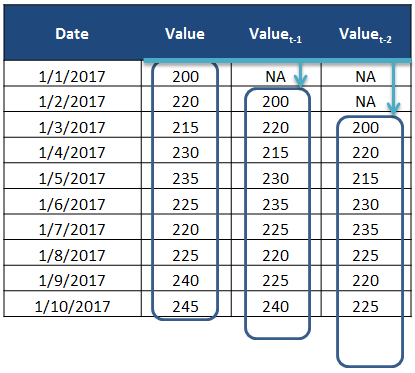

In [ ]:
def datetime(df):
  '''
  Method to convert the date column which 
  would be easily understood by pandas
  '''
  df.date = pd.to_datetime(df.date).values
  temp = df.set_index('date', drop=True)

  return temp

train = datetime(train)
test = datetime(test)

In [ ]:
def store_item_sales_asfeatures(df):
  '''
  Adds all iterations of sales (stores x items) as features to the DataFrame
  '''

  temp = pd.DataFrame(index=df.index.unique())

  for i, j in product(range(1,51), range(1,11)):
    temp[f'item_{i}_store_{j}_sales'] = df[(df['item'] == i) & (df['store'] == j)]['sales'].values

  return temp

In [ ]:
# adding features to train and test dataset

df_train = store_item_sales_asfeatures(train)

test['sales'] = np.zeros(test.shape[0]) # creates a dummy list of sales with 0 as values
df_test = store_item_sales_asfeatures(test)

df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])

In [ ]:
df_train.shape

(1826, 501)

In [ ]:
df_test.shape

(90, 501)

In [ ]:
df_total.shape # concatenating train and test

(1916, 501)

In [ ]:
# date related features like weekday and month are added to the dataset

temp1 = pd.get_dummies(df_total.index.weekday, prefix='weekday')
temp1.index = df_total.index

temp2 = pd.get_dummies(df_total.index.month, prefix='month')
temp2.index =  df_total.index

df_total = pd.concat([temp1, temp2, df_total], axis=1)

In [ ]:
df_total.shape # 19 more features added using weekdays and months

(1916, 520)

In [ ]:
def lags(df, days):
  '''
  Lags are just shifted sales values by N steps.
  This comes from the idea of using previous days sales value to predict the next day value.

  We shift the sales features by 1 to make this happen, The 't' day sale value will be 
  used by the 't+1' day as an 'X' feature to predict the 'y' variable i.e, the forecast for next day.
  '''

  names = list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', product(range(1,51), range(1,11))))

  dfs = [df.copy()]

  temp = pd.DataFrame(index=df.index.copy())

  for i in names:
      temp[str(i)+'_past_'+str(days)] = df[i].transform(lambda x: x.shift(days)) # lag features have "past" tag so we can filter them easiy

  dfs.append(temp)
  return pd.concat(dfs, axis=1, copy=False)

df_total = lags(df_total, 1)
df_total = df_total.dropna()  # remove 1st row as those are NaN values

In [ ]:
df_total.shape

(1915, 1020)

In [ ]:
df_total.head(2)

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,item_1_store_1_sales,item_1_store_2_sales,item_1_store_3_sales,item_1_store_4_sales,item_1_store_5_sales,item_1_store_6_sales,item_1_store_7_sales,item_1_store_8_sales,item_1_store_9_sales,item_1_store_10_sales,item_2_store_1_sales,item_2_store_2_sales,item_2_store_3_sales,item_2_store_4_sales,item_2_store_5_sales,item_2_store_6_sales,item_2_store_7_sales,item_2_store_8_sales,item_2_store_9_sales,item_2_store_10_sales,item_3_store_1_sales,...,item_47_store_1_sales_past_1,item_47_store_2_sales_past_1,item_47_store_3_sales_past_1,item_47_store_4_sales_past_1,item_47_store_5_sales_past_1,item_47_store_6_sales_past_1,item_47_store_7_sales_past_1,item_47_store_8_sales_past_1,item_47_store_9_sales_past_1,item_47_store_10_sales_past_1,item_48_store_1_sales_past_1,item_48_store_2_sales_past_1,item_48_store_3_sales_past_1,item_48_store_4_sales_past_1,item_48_store_5_sales_past_1,item_48_store_6_sales_past_1,item_48_store_7_sales_past_1,item_48_store_8_sales_past_1,item_48_store_9_sales_past_1,item_48_store_10_sales_past_1,item_49_store_1_sales_past_1,item_49_store_2_sales_past_1,item_49_store_3_sales_past_1,item_49_store_4_sales_past_1,item_49_store_5_sales_past_1,item_49_store_6_sales_past_1,item_49_store_7_sales_past_1,item_49_store_8_sales_past_1,item_49_store_9_sales_past_1,item_49_store_10_sales_past_1,item_50_store_1_sales_past_1,item_50_store_2_sales_past_1,item_50_store_3_sales_past_1,item_50_store_4_sales_past_1,item_50_store_5_sales_past_1,item_50_store_6_sales_past_1,item_50_store_7_sales_past_1,item_50_store_8_sales_past_1,item_50_store_9_sales_past_1,item_50_store_10_sales_past_1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,11.0,16.0,8.0,12.0,9.0,6.0,4.0,10.0,9.0,14.0,43.0,33.0,27.0,28.0,22.0,18.0,23.0,25.0,26.0,34.0,30.0,...,17.0,12.0,10.0,23.0,9.0,5.0,4.0,19.0,6.0,11.0,21.0,45.0,28.0,34.0,21.0,21.0,27.0,27.0,28.0,25.0,18.0,29.0,21.0,12.0,9.0,11.0,19.0,12.0,11.0,17.0,30.0,43.0,45.0,38.0,19.0,20.0,21.0,45.0,36.0,33.0
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,14.0,16.0,10.0,8.0,12.0,11.0,8.0,12.0,20.0,16.0,23.0,46.0,38.0,37.0,26.0,20.0,13.0,34.0,33.0,34.0,14.0,...,15.0,13.0,12.0,11.0,10.0,10.0,4.0,16.0,14.0,13.0,26.0,37.0,32.0,26.0,22.0,20.0,21.0,35.0,38.0,24.0,10.0,25.0,14.0,18.0,13.0,10.0,13.0,27.0,16.0,13.0,32.0,57.0,47.0,35.0,25.0,23.0,30.0,54.0,44.0,37.0


In [ ]:
# reordering columns

sales_columns = [i for i in df_total.columns if '_sales' in i and '_sales_' not in i]
lag_sales_columns = [i for i in df_total.columns if '_sales_' in i]
other_columns = [i for i in df_total.columns if i not in set(sales_columns) and i not in set(lag_sales_columns)]

sales_cols = sorted(sales_columns)
lag_sales_cols = sorted(lag_sales_columns)

new_order = other_columns + lag_sales_columns + sales_columns

df_total = df_total.reindex(columns=new_order)

In [ ]:
df_total.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,is_test,item_1_store_1_sales_past_1,item_1_store_2_sales_past_1,item_1_store_3_sales_past_1,item_1_store_4_sales_past_1,item_1_store_5_sales_past_1,item_1_store_6_sales_past_1,item_1_store_7_sales_past_1,item_1_store_8_sales_past_1,item_1_store_9_sales_past_1,item_1_store_10_sales_past_1,item_2_store_1_sales_past_1,item_2_store_2_sales_past_1,item_2_store_3_sales_past_1,item_2_store_4_sales_past_1,item_2_store_5_sales_past_1,item_2_store_6_sales_past_1,item_2_store_7_sales_past_1,item_2_store_8_sales_past_1,item_2_store_9_sales_past_1,item_2_store_10_sales_past_1,...,item_47_store_1_sales,item_47_store_2_sales,item_47_store_3_sales,item_47_store_4_sales,item_47_store_5_sales,item_47_store_6_sales,item_47_store_7_sales,item_47_store_8_sales,item_47_store_9_sales,item_47_store_10_sales,item_48_store_1_sales,item_48_store_2_sales,item_48_store_3_sales,item_48_store_4_sales,item_48_store_5_sales,item_48_store_6_sales,item_48_store_7_sales,item_48_store_8_sales,item_48_store_9_sales,item_48_store_10_sales,item_49_store_1_sales,item_49_store_2_sales,item_49_store_3_sales,item_49_store_4_sales,item_49_store_5_sales,item_49_store_6_sales,item_49_store_7_sales,item_49_store_8_sales,item_49_store_9_sales,item_49_store_10_sales,item_50_store_1_sales,item_50_store_2_sales,item_50_store_3_sales,item_50_store_4_sales,item_50_store_5_sales,item_50_store_6_sales,item_50_store_7_sales,item_50_store_8_sales,item_50_store_9_sales,item_50_store_10_sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,False,13.0,12.0,19.0,10.0,11.0,20.0,7.0,16.0,11.0,14.0,33.0,41.0,43.0,30.0,26.0,27.0,21.0,39.0,31.0,36.0,...,15.0,13.0,12.0,11.0,10.0,10.0,4.0,16.0,14.0,13.0,26.0,37.0,32.0,26.0,22.0,20.0,21.0,35.0,38.0,24.0,10.0,25.0,14.0,18.0,13.0,10.0,13.0,27.0,16.0,13.0,32.0,57.0,47.0,35.0,25.0,23.0,30.0,54.0,44.0,37.0
2013-01-03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,False,11.0,16.0,8.0,12.0,9.0,6.0,4.0,10.0,9.0,14.0,43.0,33.0,27.0,28.0,22.0,18.0,23.0,25.0,26.0,34.0,...,5.0,5.0,13.0,11.0,14.0,10.0,4.0,8.0,18.0,16.0,25.0,45.0,40.0,33.0,24.0,27.0,11.0,22.0,24.0,29.0,17.0,30.0,22.0,22.0,16.0,16.0,9.0,16.0,20.0,19.0,25.0,45.0,39.0,32.0,28.0,38.0,20.0,54.0,29.0,46.0
2013-01-04,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,False,14.0,16.0,10.0,8.0,12.0,11.0,8.0,12.0,20.0,16.0,23.0,46.0,38.0,37.0,26.0,20.0,13.0,34.0,33.0,34.0,...,13.0,19.0,5.0,18.0,10.0,11.0,9.0,17.0,15.0,11.0,26.0,32.0,39.0,26.0,34.0,21.0,17.0,32.0,30.0,39.0,22.0,20.0,26.0,17.0,12.0,18.0,9.0,18.0,19.0,23.0,32.0,45.0,48.0,36.0,27.0,33.0,27.0,52.0,43.0,51.0
2013-01-05,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,False,13.0,20.0,15.0,15.0,8.0,7.0,7.0,21.0,22.0,17.0,18.0,50.0,35.0,44.0,23.0,24.0,34.0,39.0,42.0,50.0,...,12.0,18.0,14.0,18.0,7.0,9.0,8.0,18.0,13.0,16.0,28.0,53.0,47.0,33.0,24.0,24.0,28.0,40.0,33.0,34.0,15.0,20.0,22.0,19.0,19.0,13.0,12.0,21.0,16.0,22.0,35.0,55.0,46.0,47.0,31.0,33.0,18.0,48.0,53.0,41.0
2013-01-06,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,False,10.0,16.0,22.0,19.0,13.0,12.0,8.0,15.0,22.0,12.0,34.0,44.0,47.0,36.0,22.0,32.0,25.0,45.0,50.0,42.0,...,13.0,25.0,14.0,16.0,12.0,17.0,17.0,18.0,14.0,17.0,38.0,45.0,28.0,41.0,21.0,26.0,24.0,46.0,38.0,47.0,19.0,23.0,36.0,14.0,14.0,19.0,14.0,22.0,20.0,23.0,40.0,56.0,52.0,43.0,24.0,28.0,26.0,51.0,38.0,41.0


# Preprocessing data

The preprocessing data consists of following steps:

1. Normalize the lag features which is necessary for ML algorithm.
2. Separate the train and test set.
3. Split the train set into train and validation. This validation set will be used for tuning the hyperparameters.
4. Now the data is ready to be used as input to any machine learning regression method.

In [ ]:
# Normalizing the data so that it lies between (0,1)

scaler = MinMaxScaler()

columns_scale = [i for i in df_total.columns if 'weekday' not in i and 'month' not in i]
columns_scaled = scaler.fit_transform(df_total[columns_scale])
df_total[columns_scale] = columns_scaled

# split the train and test sets

df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

# separating 'X' and 'y' variables

lag_columns = [i for i in df_train.columns if '_past_' in i]
date_columns = [i for i in df_train.columns if 'weekday_' in i or 'month_' in i]
final_columns = lag_columns + date_columns

X = df_train[final_columns]

final_columns_set = set(final_columns)
y_columns = [i for i in df_train.columns if i not in final_columns_set]

y = df_train[y_columns]

In [ ]:
X.shape # using 519 features for traininig ML model

# features include date related features and lag features

(1825, 519)

In [ ]:
y.shape # 500 values are to be predicted in each array for 10 stores and 50 items

(1825, 500)

In [ ]:
# split values to train and test, use np arrays to allow reshaping
x_train = X.iloc[X.index < "2017-10-01", :]
y_train = y.iloc[y.index < "2017-10-01", :]

x_valid = X.iloc[X.index >= "2017-10-01", :]
y_valid = y.iloc[y.index >= "2017-10-01", :]

# reshaping the 'X' features in the input format for LSTM

x_train_reshape = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_valid_reshape = x_valid.values.reshape((x_valid.shape[0], 1, x_valid.shape[1]))

In [ ]:
x_train_reshape.shape

(1733, 1, 519)

# Model Training

1. LSTM was chosen with three hyperparameters namely, *learning_rate* and *epochs* and *batch_size*.
2. Optuna integration on the model makes it very simple to tune the hyperparameters based on the validation score. The validation metric that's chosen here is Mean Absolute Error (MAE). We run trials and choose the hyperparameters based on how quicker the algorithm converges to the optimal value.
3. For MAE, our objective is to minimize the metric.
4. After all the trials, we pick the best model which gives the least validation score (MAE) and this model is used to forecast sales values on test data.
5. Optuna shows the most important hyperparameter which helped the method to converge quickly to the optimal solution.
6. Metrics like MAE, RMSE (Root Mean Squared Error), and R Squared are used to judge the performance of the best regression model on validation data. As one metric does not tell the same story, it is better to use multiple metrics which have its pros and cons.

In [ ]:
'''
Optuna picks the hyperparameters based on the step size and begins to do trials by
selecting random hyperparameters at first and as we calculate the metrics, it tries to
select hyperparameters which will minimize/ maximize the given metric.

In our case, we used the MAE metric which should be minimized.
'''

def unscale(y, concat_df):
    """
    Inverse transform the normalized values
    """
    temp = concat_df.copy()
    temp[y_columns] = pd.DataFrame(y, index=temp.index)
    temp[columns_scale] = scaler.inverse_transform(temp[columns_scale])
 
    return temp[y_columns].astype(int)

def objective(trial):

  learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
  epochs = trial.suggest_int("epochs", 200, 400,step=100, log=False)
  batch_size = trial.suggest_int("batch_size", 10, 50,step=10, log=False)

  model = Sequential()
  model.add(LSTM(4, input_shape=(x_train_reshape.shape[1], x_train_reshape.shape[2])))
  model.add(Dense(y_train.shape[1]))
  model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate))
  model.fit(x_train_reshape, y_train.values, epochs=epochs, batch_size=batch_size, verbose=0)

  # make predictions
  y_pred = model.predict(x_valid_reshape)

  # inverse transform
  concat_df = pd.concat([x_valid, y_valid], axis=1)
  concat_df['is_test'] = np.repeat(True, concat_df.shape[0])

  validation_pred = unscale(y_pred, concat_df)
  validation_actual = unscale(y_valid, concat_df)

  mae = mean_absolute_error(validation_pred, validation_actual)


  # Handle pruning based on the intermediate value
  if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  return mae


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=None)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = study.best_trial.params

[I 2021-07-24 17:12:52,082] A new study created in memory with name: no-name-526cffdb-8432-4402-8b4e-dd14a04c9a5b
[I 2021-07-24 17:15:41,493] Trial 0 finished with value: 6.124717391304348 and parameters: {'learning_rate': 0.0026173199692527682, 'epochs': 400, 'batch_size': 10}. Best is trial 0 with value: 6.124717391304348.


[I 2021-07-24 17:17:50,367] Trial 1 finished with value: 6.056108695652174 and parameters: {'learning_rate': 0.001134211449144974, 'epochs': 300, 'batch_size': 10}. Best is trial 1 with value: 6.056108695652174.


[I 2021-07-24 17:19:58,992] Trial 2 finished with value: 10.285260869565215 and parameters: {'learning_rate': 0.012506811447750612, 'epochs': 300, 'batch_size': 10}. Best is trial 1 with value: 6.056108695652174.
[I 2021-07-24 17:20:44,544] Trial 3 finished with value: 10.35 and parameters: {'learning_rate': 0.05568854703221366, 'epochs': 300, 'batch_size': 30}. Best is trial 1 with value: 6.056108695652174.
[I 2021-07-24 17:21:31,436] Trial 4 finished with value: 6.282021739130435 and parameters: {'learning_rate': 0.006174761209633642, 'epochs': 400, 'batch_size': 40}. Best is trial 1 with value: 6.056108695652174.
[I 2021-07-24 17:22:18,863] Trial 5 finished with value: 10.966695652173913 and parameters: {'learning_rate': 0.055265156452276226, 'epochs': 400, 'batch_size': 40}. Best is trial 1 with value: 6.056108695652174.
[I 2021-07-24 17:23:04,987] Trial 6 finished with value: 10.634695652173912 and parameters: {'learning_rate': 0.01665248510303448, 'epochs': 300, 'batch_size': 30}

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  5.944326086956522
  Params: 
    learning_rate: 0.002616924034573797
    epochs: 200
    batch_size: 50


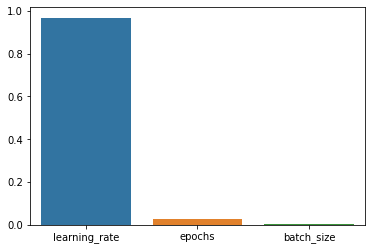

In [ ]:
'''
This plot shows the feature importance during the training 
process. It means that tuning learning rate is more important to
find the optimal solution than tuning other hyperparameters.
'''

D = optuna.importance.get_param_importances(study)
plt.figure()
sns.barplot(x = list(D.keys()),y =  list(D.values()))

In [ ]:
# rerun model with optimal hyperparameters 


model = Sequential()
model.add(LSTM(4, input_shape=(x_train_reshape.shape[1], x_train_reshape.shape[2])))
model.add(Dense(y_train.shape[1]))
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=best_params['learning_rate']))
model.fit(x_train_reshape, y_train.values, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# make predictions
y_pred = model.predict(x_valid_reshape)

# inverse transform
concat_df = pd.concat([x_valid, y_valid], axis=1)
concat_df['is_test'] = np.repeat(True, concat_df.shape[0])

validation_pred = unscale(y_pred, concat_df)
validation_actual = unscale(y_valid, concat_df)

model.save('saved_models/lstm.model')

print('MAE: ',mean_absolute_error(validation_pred, validation_actual))
print('RMSE: ',sqrt(mean_squared_error(validation_pred, validation_actual)))
print('R2: ',r2_score(validation_pred, validation_actual))

INFO:tensorflow:Assets written to: saved_models/lstm.model/assets


INFO:tensorflow:Assets written to: saved_models/lstm.model/assets


MAE:  6.055217391304348
RMSE:  8.006326302966
R2:  0.2537097973025854


# Plots relating to Sales forecast on validation set and test set

Just as in the plots in XGBoost notebook, first plot shows the plot of one store and one item (specifically store 1, item 1) of validation set (actual and predicted)

Second plot aggregates the sales values of every store and item to make a visualization of sales values of all stores and items (of validation set (actual and predicted))

Third plot shows sales values and predictions on validation and test set, along with the visualization for train set sales values

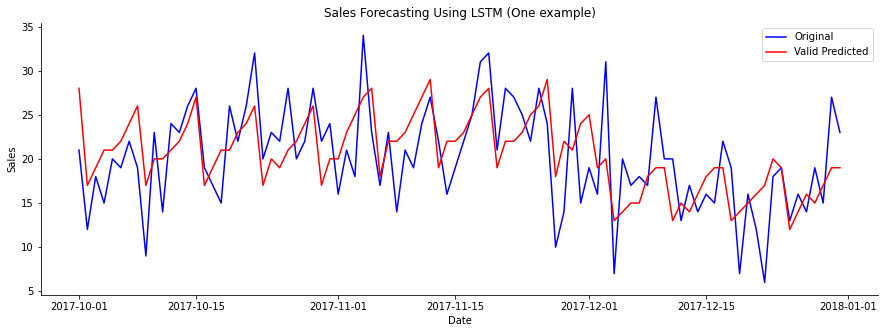

In [ ]:
'''
Plot showing the actual values and predicted values for the validation set.
The data includes 3 month sales values.

Since it is difficult to plot all predictions in one plot, forecast of one 
store and one item is chosen.

The plot below this shows visualization of aggregated values.

'''

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=validation_actual['item_1_store_1_sales'], ax=ax, 
              label='Original', color='blue')
sns.lineplot(data=validation_pred['item_1_store_1_sales'], ax=ax, 
              label='Valid Predicted', color='Red')


ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Sales Forecasting Using LSTM (One example)")

ax.legend()
plt.savefig( 'images/lstm-train-valid-single.jpg', bbox_inches='tight', dpi=200)


sns.despine()

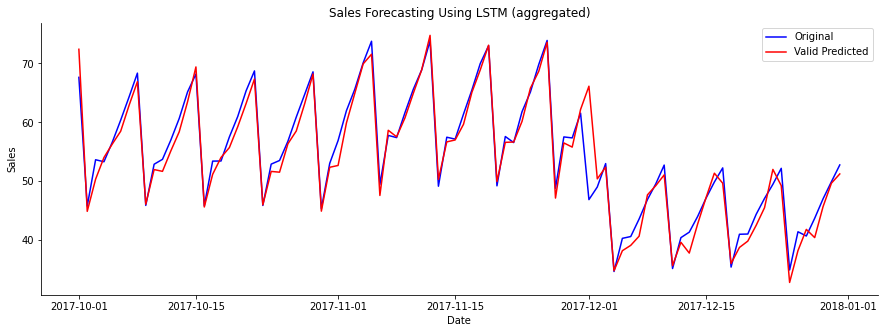

In [ ]:
'''
Visualization of aggregated sales values

The model performs better for global/ aggregated insights than
individual forecasts.
'''

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=validation_actual.mean(axis=1), ax=ax, 
              label='Original', color='blue')
sns.lineplot(data=validation_pred.mean(axis=1), ax=ax, 
              label='Valid Predicted', color='Red')


ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Sales Forecasting Using LSTM (aggregated)")

ax.legend()
plt.savefig( 'images/lstm-train-valid-agg.jpg', bbox_inches='tight', dpi=200)


sns.despine()

In [ ]:
# prediction on test set

test_set = df_test[final_columns]
test_set_reshape = test_set.values.reshape((test_set.shape[0], 1, test_set.shape[1]))

y_pred_test = model.predict(test_set_reshape)

temp = y_valid
temp.drop(temp.index[[1,2]], inplace=True)
temp.set_index(test_set.index, inplace=True)


# inverse transform
concat_df = pd.concat([test_set, temp], axis=1)
concat_df['is_test'] = np.repeat(True, concat_df.shape[0])

test_pred = unscale(y_pred_test, concat_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
test_pred.to_csv('predictions_lstm.csv')

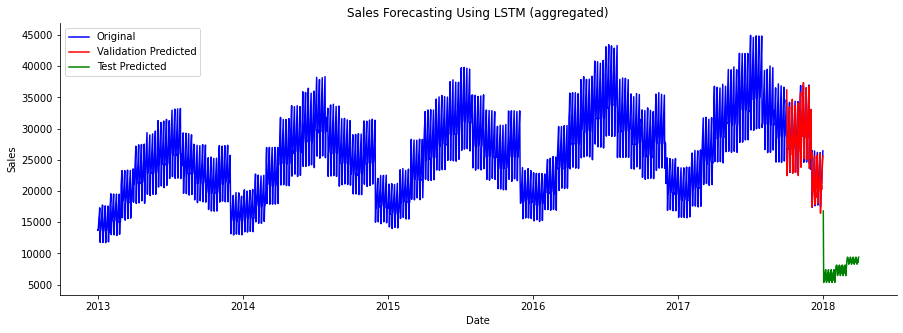

In [ ]:
'''
Visualization of aggregated sales values of train, valid and test data

The model performs better for global/ aggregated insights than
individual forecasts.

From the visualization we can see that LSTM model does not perform better at the 
test time.

'''

train_df = pd.read_csv('data/train.csv')
train_df = datetime(train_df)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=train_df.resample('D').sum().sales, ax=ax, 
              label='Original', color='blue')
sns.lineplot(data=validation_pred.sum(axis=1), ax=ax, 
              label='Validation Predicted', color='Red')
sns.lineplot(data=test_pred.sum(axis=1), ax=ax, 
              label='Test Predicted', color='green')


ax.set(xlabel = "Date",
        ylabel = "Sales",
        title = "Sales Forecasting Using LSTM (aggregated)")

ax.legend()
plt.savefig( 'images/lstm-alldata.jpg', bbox_inches='tight', dpi=200)


sns.despine()